In [13]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder

import plotly.express as px
import plotly.graph_objects as go
# import plotly.io as pio
# pio.renderers.default = 'jupyterlab'

from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.tree import export_graphviz
from IPython.display import Image  
from pydotplus import graph_from_dot_data

from functions import *
from DrawTree import DrawTree

from sklearn.model_selection import GridSearchCV

In [14]:
df = load_data()
df.dropna(inplace=True)

### Predicting Customer Churn with a Decision Tree

In [5]:
from sklearn.model_selection import StratifiedKFold,train_test_split

X = df.drop(columns=['Churn','customerID','TotalCharges'])
Y = df['Churn']

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=.2,stratify=df[['One year','Two year','Churn']])


num_features = ['MonthlyCharges']
ord_features = ['tenure']

from sklearn.preprocessing import StandardScaler

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

decision_tree = DecisionTreeClassifier(max_depth=4)

sm_pipeline = make_pipeline(
                            SMOTE(n_jobs=-1,random_state=43),
                            decision_tree
                           )

fit = sm_pipeline.fit(X_train,y_train)

y_pred = fit.predict(X_test)

from sklearn.metrics import classification_report
from sklearn import metrics

pd.DataFrame(classification_report(y_test,y_pred,output_dict=True))

Using TensorFlow backend.


0           1  accuracy    macro avg  weighted avg
precision     0.880044    0.536585  0.760114     0.708314      0.788877
recall        0.779710    0.705882  0.760114     0.742796      0.760114
f1-score      0.826844    0.609700  0.760114     0.718272      0.769206
support    1035.000000  374.000000  0.760114  1409.000000   1409.000000

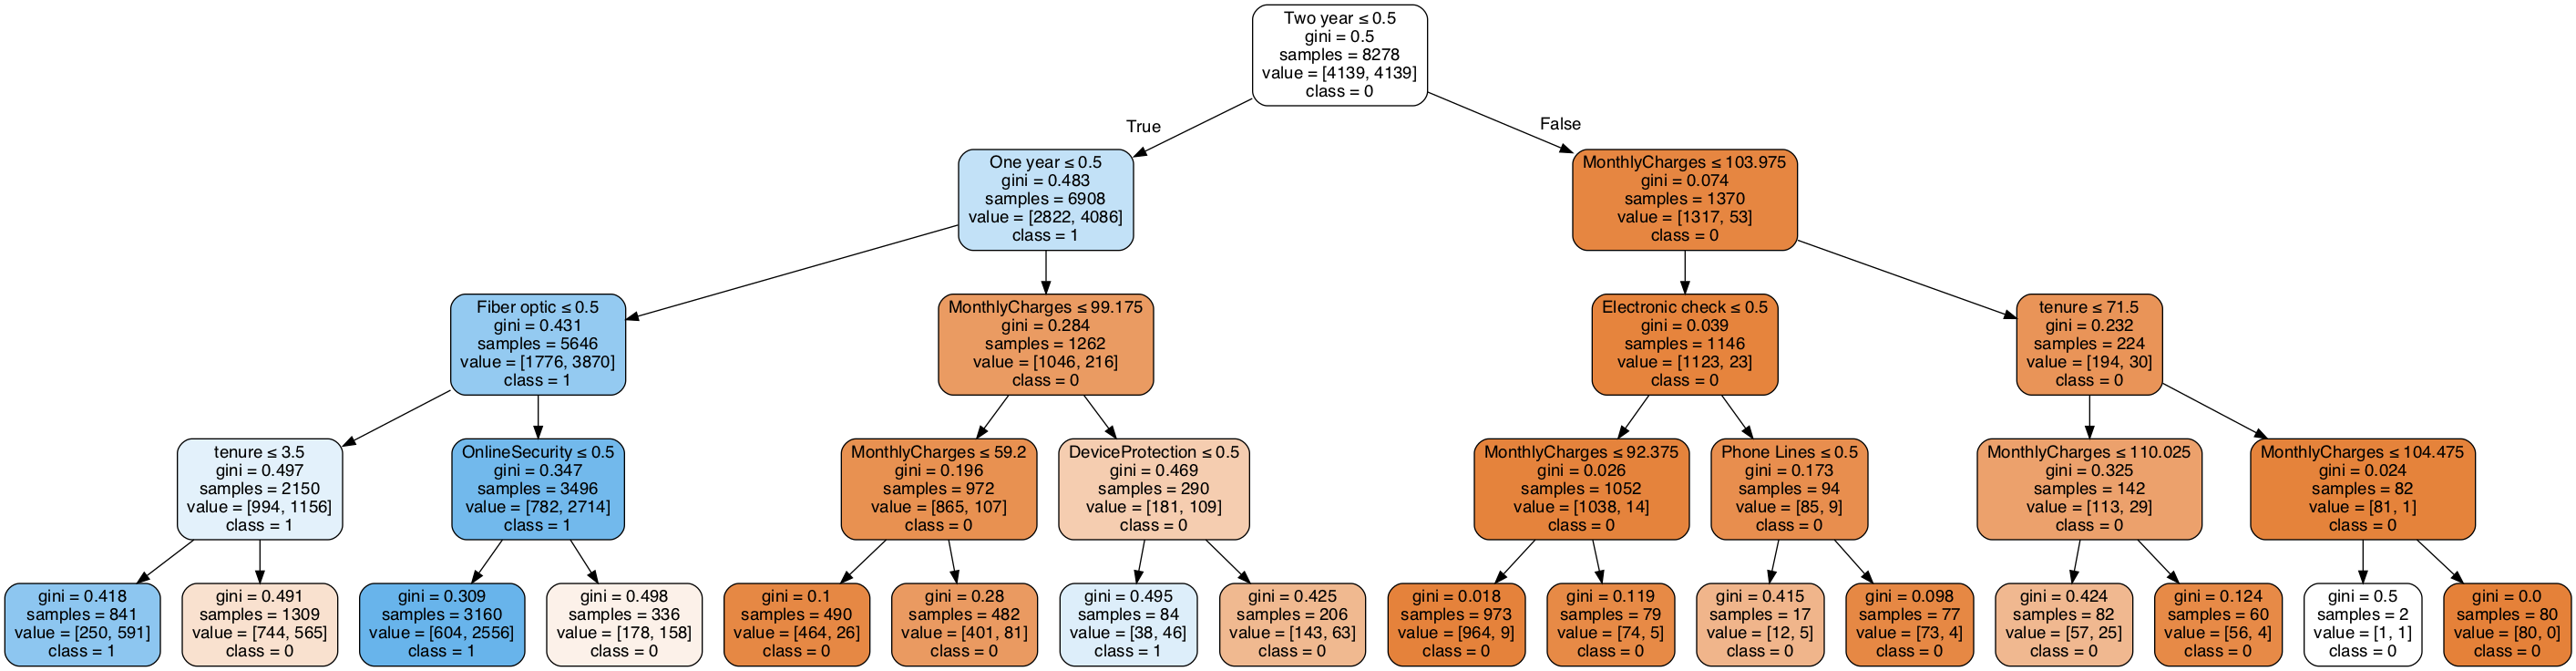

In [6]:
plot_tree(decision_tree,X_train,y_train)

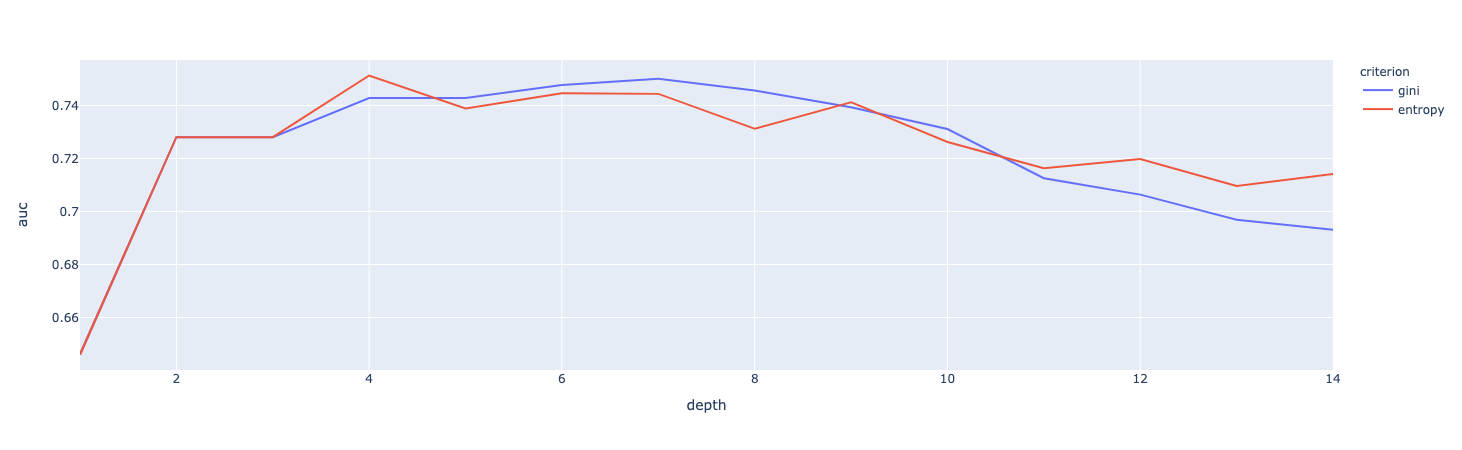

In [7]:
results = []
for i in range(1,15):
    for crit in ['gini','entropy']:
        decision_tree = DecisionTreeClassifier(max_depth=i,criterion=crit,max_features=None)

        sm_pipeline = make_pipeline(
                                    SMOTE(n_jobs=-1,random_state=43),
                                    decision_tree
                                   )

        fit = sm_pipeline.fit(X_train,y_train)

        y_pred = fit.predict(X_test)

        recall = metrics.recall_score(y_test,y_pred,pos_label=1)
        precision = metrics.precision_score(y_test,y_pred,pos_label=1)
        auc = metrics.roc_auc_score(y_test,y_pred,average='micro')
    
        results.append({'depth':i,'recall':recall,'precision':precision,'auc':auc,'criterion':crit})
tree_performance = pd.DataFrame.from_records(results)
px.line(data_frame=tree_performance,x='depth',y='auc',color='criterion')

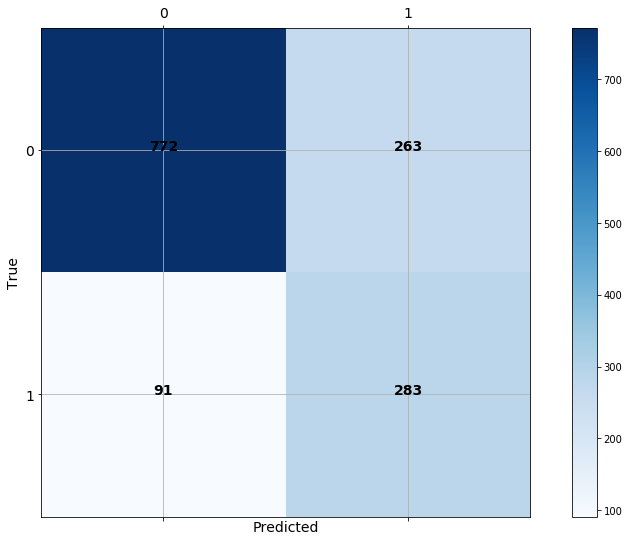

In [8]:
decision_tree = DecisionTreeClassifier(max_depth=4,criterion='entropy')

sm_pipeline = make_pipeline(
                            SMOTE(n_jobs=-1,random_state=43),
                            decision_tree
                           )

fit = sm_pipeline.fit(X_train,y_train)

y_pred = fit.predict(X_test)

plot_confusion_matrix(y_test,y_pred,classes=[0,1])

### Customer Lifetime Value

We can only look at CLTV for those who have already churned. 

Here is the formula for Customer Lifetime Value:

![CLV formula](images/CLV_formula.png)

ARPA equals the average revenue per account for a period of time (e.g. monthly). 

I'm going to use a decision tree to predict monthly rate and use the resulting leaves to group customers.

In [250]:
df[df['TotalCharges'].isna()]['One year']

488     0
753     0
936     0
1082    0
1340    0
3331    0
3826    0
4380    0
5218    1
6670    0
6754    0
Name: One year, dtype: uint8

In [236]:
def clv(df,n_leaves,show=False):
    train_set, test_set = train_test_split(df.copy(),stratify=df['Churn'])

    X_train = train_set.drop(columns=['Churn','customerID','TotalCharges','tenure','MonthlyCharges'])
    y_train = train_set['MonthlyCharges']

    X_test = test_set.drop(columns=['Churn','customerID','TotalCharges','tenure','MonthlyCharges'])
    y_test = test_set['MonthlyCharges']

    rate_tree = DecisionTreeRegressor(max_leaf_nodes=n_leaves)

    params = {
        'max_features':['sqrt','auto','log2'],
        'criterion':['mse','friedman_mse'],
        'ccp_alpha':[.001,0.0],
        'min_samples_split':[.1,.2]
    }

    search = GridSearchCV(rate_tree,params)

    rate_pipe = Pipeline([
        ('scaler',StandardScaler()),
        ('tree',search)
    ])

    fit = rate_pipe.fit(X_train,y_train)

    train_set['leaf'] = search.best_estimator_.apply(X_train)
    train_set['leaf'] = 'leaf '+train_set['leaf'].astype(str)
    train_set.replace(' ',np.nan,inplace=True)

    groupby_leaf = train_set.groupby('leaf')[['MonthlyCharges','Churn','TotalCharges']].mean()
    groupby_leaf['predicted_clv']=(1/(groupby_leaf['Churn']))*groupby_leaf['MonthlyCharges']

    clv_map = groupby_leaf['Churn'].to_dict()
    train_set['churn_rate'] = train_set['leaf'].map(clv_map)
    
    train_set['predicted_clv'] = train_set.apply(lambda x: (1/x['churn_rate']) * x['MonthlyCharges'],axis=1)
    
    if show:
        print(search.best_params_)
        fig = px.scatter(train_set[train_set['Churn']==1],y='TotalCharges',x='predicted_clv')
        fig.show()
    
    mse = metrics.mean_squared_error(
        train_set[train_set['Churn']==1]['TotalCharges'],
        train_set[train_set['Churn']==1]['predicted_clv']
    )

    return mse

{'ccp_alpha': 0.001, 'criterion': 'mse', 'max_features': 'auto', 'min_samples_split': 0.1}


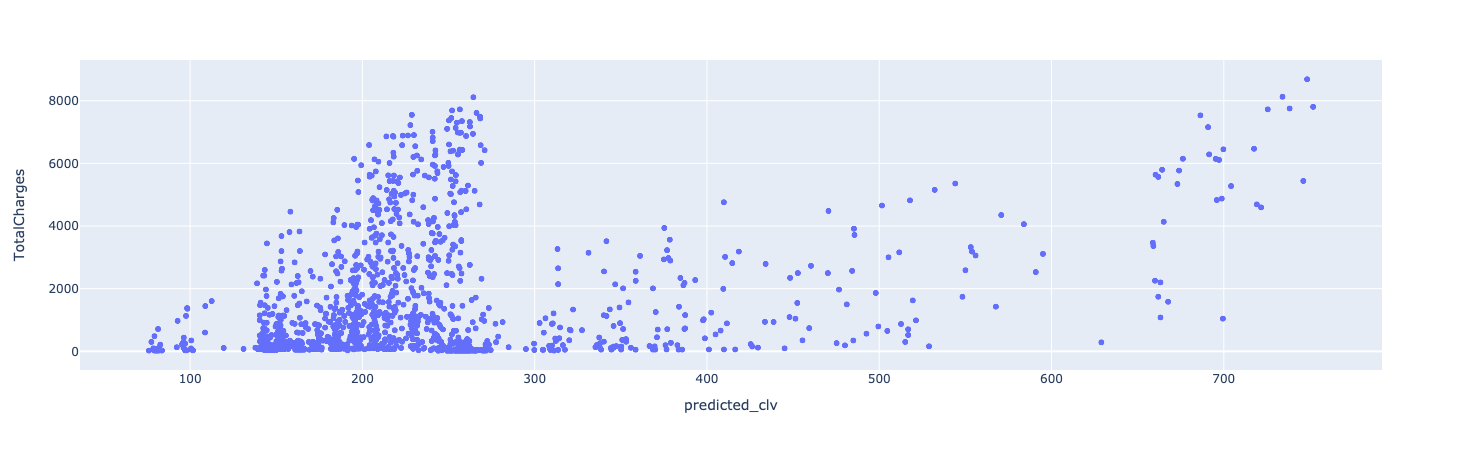

5254406.304023753

In [238]:
clv(df,50,show=True)

In [239]:
train_set

customerID  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
578   6522-YRBXD              1        1           0      35             1   
1443  7055-HNEOJ              0        1           0       3             1   
518   0257-ZESQC              1        1           0      27             1   
3242  3717-FDJFU              0        0           1       5             1   
5444  1833-TCXKK              0        1           0      45             1   
...          ...            ...      ...         ...     ...           ...   
5663  2824-MYYBN              0        1           1      37             1   
6229  6631-HMANX              0        1           0      72             1   
4936  3898-GUYTS              1        0           0      45             1   
2767  3572-UOLYZ              0        0           1      46             1   
2805  9372-TXXPS              0        1           0      60             1   

      InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  ...  \
578                 1               1             1                 0  ...   
1443                1               0             0                 1  ...   
518                 1               1             0                 0  ...   
3242                0               0             0                 0  ...   
5444                1               0             1                 1  ...   
...               ...             ...           ...               ...  ...   
5663                1               0             0                 0  ...   
6229                1               0             1                 1  ...   
4936                1               1             1                 0  ...   
2767                1               0             0                 1  ...   
2805                1               1             1                 0  ...   

      One year  Two year  Credit card (automatic)  Electronic check  \
578          0         0                        0                 1   
1443         0         0                        0                 0   
518          0         0                        0                 0   
3242         0         1                        0                 0   
5444         0         0                        0                 0   
...        ...       ...                      ...               ...   
5663         0         0                        0                 1   
6229         0         1                        1                 0   
4936         0         0                        0                 1   
2767         0         0                        0                 0   
2805         0         1                        0                 0   

      Mailed check  Male  DSL  Fiber optic     leaf  predicted_clv  
578              0     1    0            1  leaf 81     551.109375  
1443             1     1    1            0  leaf 27     160.650000  
518              0     0    0            1  leaf 59     131.338362  
3242             1     1    0            0   leaf 3     251.673611  
5444             0     1    0            1  leaf 89     306.864655  
...            ...   ...  ...          ...      ...            ...  
5663             0     0    0            1  leaf 85     152.961905  
6229             0     1    1            0  leaf 53    5636.250000  
4936             0     0    0            1  leaf 73     616.621429  
2767             0     0    0            1  leaf 63     227.381250  
2805             0     0    1            0  leaf 32     491.405000  

[5282 rows x 28 columns]

In [227]:
results = []
for n in range(40,60):
    mse = {'leaves':n,'mse':clv(df,n)}
    results.append(mse)

ZeroDivisionError: float division by zero

In [ ]:
sorted(results,key=lambda x: x['mse'])